In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

import torch
from torch import nn,optim
from umap import UMAP

import random
random.seed(17928456)



In [2]:
songs = pd.read_csv("musicData.csv")
songs

instance_id           artist_name                track_name  \
0          32894.0              Röyksopp      Röyksopp's Night Out   
1          46652.0  Thievery Corporation          The Shining Path   
2          30097.0        Dillon Francis                 Hurricane   
3          62177.0              Dubloadz                     Nitro   
4          24907.0           What So Not          Divide & Conquer   
...            ...                   ...                       ...   
50000      58878.0                 BEXEY                  GO GETTA   
50001      43557.0             Roy Woods       Drama (feat. Drake)   
50002      39767.0                Berner  Lovin' Me (feat. Smiggz)   
50003      57944.0             The-Dream         Shawty Is Da Shit   
50004      63470.0     Naughty By Nature            Hip Hop Hooray   

       popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652         -1.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
50000        59.0       0.03340         0.913         -1.0   0.574   
50001        72.0       0.15700         0.709     251860.0   0.362   
50002        51.0       0.00597         0.693     189483.0   0.763   
50003        65.0       0.08310         0.782     262773.0   0.472   
50004        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness key  liveness  loudness   mode  speechiness  \
0               0.79200  A#     0.115    -5.201  Minor       0.0748   
1               0.95000   D     0.124    -7.043  Minor       0.0300   
2               0.01180  G#     0.534    -4.617  Major       0.0345   
3               0.00253  C#     0.157    -4.498  Major       0.2390   
4               0.90900  F#     0.157    -6.266  Major       0.0413   
...                 ...  ..       ...       ...    ...          ...   
50000           0.00000  C#     0.119    -7.022  Major       0.2980   
50001           0.00000   B     0.109    -9.814  Major       0.0550   
50002           0.00000   D     0.143    -5.443  Major       0.1460   
50003           0.00000   G     0.106    -5.016  Minor       0.0441   
50004           0.00000  F#     0.272   -13.652  Minor       0.1010   

                    tempo obtained_date  valence music_genre  
0                 100.889         4-Apr    0.759  Electronic  
1      115.00200000000001         4-Apr    0.531  Electronic  
2                 127.994         4-Apr    0.333  Electronic  
3                 128.014         4-Apr    0.270  Electronic  
4                 145.036         4-Apr    0.323  Electronic  
...                   ...           ...      ...         ...  
50000   98.02799999999999         4-Apr    0.330     Hip-Hop  
50001  122.04299999999999         4-Apr    0.113     Hip-Hop  
50002             131.079         4-Apr    0.395     Hip-Hop  
50003   75.88600000000001         4-Apr    0.354     Hip-Hop  
50004   99.20100000000001         4-Apr    0.765     Hip-Hop  

[50005 rows x 18 columns]

### Standardized Data

In [3]:
df = songs.drop(['instance_id','artist_name','track_name','obtained_date'],axis=1)
df.replace("Minor",1,inplace=True)
df.replace("Major",0,inplace=True)
df.replace({'key':{'C':0,'C#':1,'D':2,'D#':3,'E':4,'F':5,'F#':6,'G':7,'G#':8,'A':8,'A#':10,'B':11}},inplace=True)
df.replace({'music_genre':{
 'Alternative':0,
 'Anime':1,
 'Blues':2,
 'Classical':3,
 'Country':4,
 'Electronic':5,
 'Hip-Hop':6,
 'Jazz':7,
 'Rap':8,
 'Rock':9}},inplace=True)
genre_list = ['Alternative','Anime','Blues','Classical','Country','Electronic','Hip-Hop','Jazz','Rap','Rock']

### Handling Nan

In [4]:
df.dropna(axis=0,how='any',inplace=True)
df.replace(-1,np.nan,inplace=True)
df.replace("?",np.nan,inplace=True)

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputed_df = pd.DataFrame(imputer.fit_transform(df),
                           columns=df.columns,
                           index=df.index)

imputed_df

popularity  acousticness  danceability    duration_ms  energy  \
0            27.0       0.00468         0.652  245503.541466   0.941   
1            31.0       0.01270         0.622  218293.000000   0.890   
2            28.0       0.00306         0.620  215613.000000   0.755   
3            34.0       0.02540         0.774  166875.000000   0.700   
4            32.0       0.00465         0.638  222369.000000   0.587   
...           ...           ...           ...            ...     ...   
50000        59.0       0.03340         0.913  245503.541466   0.574   
50001        72.0       0.15700         0.709  251860.000000   0.362   
50002        51.0       0.00597         0.693  189483.000000   0.763   
50003        65.0       0.08310         0.782  262773.000000   0.472   
50004        67.0       0.10200         0.862  267267.000000   0.642   

       instrumentalness   key  liveness  loudness  mode  speechiness    tempo  \
0               0.79200  10.0     0.115    -5.201   1.0       0.0748  100.889   
1               0.95000   2.0     0.124    -7.043   1.0       0.0300  115.002   
2               0.01180   8.0     0.534    -4.617   0.0       0.0345  127.994   
3               0.00253   1.0     0.157    -4.498   0.0       0.2390  128.014   
4               0.90900   6.0     0.157    -6.266   0.0       0.0413  145.036   
...                 ...   ...       ...       ...   ...          ...      ...   
50000           0.00000   1.0     0.119    -7.022   0.0       0.2980   98.028   
50001           0.00000  11.0     0.109    -9.814   0.0       0.0550  122.043   
50002           0.00000   2.0     0.143    -5.443   0.0       0.1460  131.079   
50003           0.00000   7.0     0.106    -5.016   1.0       0.0441   75.886   
50004           0.00000   6.0     0.272   -13.652   1.0       0.1010   99.201   

       valence  music_genre  
0        0.759          5.0  
1        0.531          5.0  
2        0.333          5.0  
3        0.270          5.0  
4        0.323          5.0  
...        ...          ...  
50000    0.330          6.0  
50001    0.113          6.0  
50002    0.395          6.0  
50003    0.354          6.0  
50004    0.765          6.0  

[50000 rows x 14 columns]

### Dimensionality Reduction

In [6]:
test = imputed_df

In [7]:
test['popularity'] = (test['popularity']-test['popularity'].min())/(test['popularity'].max()-test['popularity'].min())
test['duration_ms'] = (test['duration_ms']-test['duration_ms'].min())/(test['duration_ms'].max()-test['duration_ms'].min())
test['loudness'] = (test['loudness']-test['loudness'].min())/(test['loudness'].max()-test['loudness'].min())
test['tempo']=test['tempo'].astype(float)
test['tempo'] = (test['tempo']-test['tempo'].min())/(test['tempo'].max()-test['tempo'].min())

key_list=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
for i in key_list:
    test[i]=np.zeros(50000)

for i in range(0,50000):
    k = test.iat[i,6]
    col = int(14+k)
    test.iat[i,col]=1

test.drop('key', axis=1,inplace=True)

In [8]:
test

popularity  acousticness  danceability  duration_ms  energy  \
0        0.272727       0.00468         0.652     0.047765   0.941   
1        0.313131       0.01270         0.622     0.042114   0.890   
2        0.282828       0.00306         0.620     0.041558   0.755   
3        0.343434       0.02540         0.774     0.031436   0.700   
4        0.323232       0.00465         0.638     0.042961   0.587   
...           ...           ...           ...          ...     ...   
50000    0.595960       0.03340         0.913     0.047765   0.574   
50001    0.727273       0.15700         0.709     0.049085   0.362   
50002    0.515152       0.00597         0.693     0.036131   0.763   
50003    0.656566       0.08310         0.782     0.051352   0.472   
50004    0.676768       0.10200         0.862     0.052285   0.642   

       instrumentalness  liveness  loudness  mode  speechiness  ...    D   D#  \
0               0.79200     0.115  0.823883   1.0       0.0748  ...  0.0  0.0   
1               0.95000     0.124  0.787616   1.0       0.0300  ...  1.0  0.0   
2               0.01180     0.534  0.835381   0.0       0.0345  ...  0.0  0.0   
3               0.00253     0.157  0.837724   0.0       0.2390  ...  0.0  0.0   
4               0.90900     0.157  0.802914   0.0       0.0413  ...  0.0  0.0   
...                 ...       ...       ...   ...          ...  ...  ...  ...   
50000           0.00000     0.119  0.788029   0.0       0.2980  ...  0.0  0.0   
50001           0.00000     0.109  0.733058   0.0       0.0550  ...  0.0  0.0   
50002           0.00000     0.143  0.819118   0.0       0.1460  ...  1.0  0.0   
50003           0.00000     0.106  0.827525   1.0       0.0441  ...  0.0  0.0   
50004           0.00000     0.272  0.657492   1.0       0.1010  ...  0.0  0.0   

         E    F   F#    G   G#    A   A#    B  
0      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  ...  
50000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
50001  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
50002  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
50003  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
50004  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  

[50000 rows x 25 columns]

In [9]:
#T-SNE
'''
from sklearn.manifold import TSNE
X_sne = TSNE(n_components=3, perplexity=50,random_state=17928456)
sne = X_sne.fit_transform(test.drop(['music_genre'],axis=1))

plt.figure(figsize=(6, 6))
plt.scatter(sne[:, 0], sne[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-sne")
plt.show()
'''

'\nfrom sklearn.manifold import TSNE\nX_sne = TSNE(n_components=3, perplexity=50,random_state=17928456)\nsne = X_sne.fit_transform(test.drop([\'music_genre\'],axis=1))\n\nplt.figure(figsize=(6, 6))\nplt.scatter(sne[:, 0], sne[:, 1])\nplt.xlabel("Component 1")\nplt.ylabel("Component 2")\nplt.title("t-sne")\nplt.show()\n'

In [10]:
#Umap
umap_model = UMAP(n_components=5,n_neighbors=100,min_dist=0.7,random_state=17928456)
umap_model.fit(test.drop(['music_genre'],axis=1))
X_umap = umap_model.transform(test.drop('music_genre',axis=1))

In [11]:
# !pip install plotly
import plotly.graph_objects as go

labels = test['music_genre']
# Plot the embedding in 3D using Plotly
fig = go.Figure(data=[go.Scatter3d(x=X_umap[:, 0], y=X_umap[:, 1],z=X_umap[:, 2],mode='markers', marker=dict(size=2,color=labels, colorscale='Viridis', opacity=0.5))])
fig.show()

### Classification

In [12]:
X = X_umap
y = np.array(test['music_genre'])


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=17928456)

class_indices = [np.where(y == i)[0] for i in range(10)]

train_indices = []
test_indices = []

for indices in class_indices:
    train_index, test_index = next(splitter.split(X[indices], y[indices]))
    
    train_indices.append(indices[train_index[:4500]])
    test_indices.append(indices[test_index[:500]])

train_indices = np.concatenate(train_indices)
test_indices = np.concatenate(test_indices)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,auc,roc_curve

rf = RandomForestClassifier(n_estimators=150,random_state=17928456)
rf.fit(X_train, y_train)

y_prob = rf.predict_proba(X_test)

roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')

0.8321692444444444

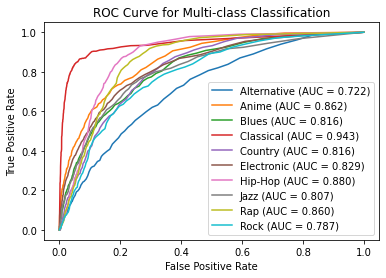

In [15]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
y_pred_bin = label_binarize(np.argmax(y_prob, axis=1), classes=[0,1,2,3,4,5,6,7,8,9])

fpr = {}
tpr = {}
roc_auc = {}
n_classes = 10  # number of classes
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='%s (AUC = %0.3f)' % (genre_list[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()


### EC

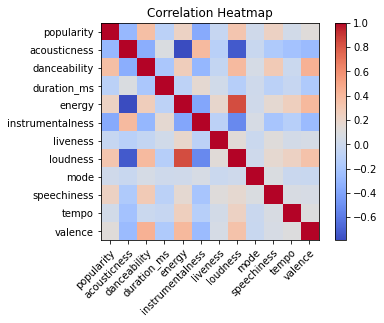

In [16]:
corr_test = test.drop(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B','music_genre'],axis=1)

corr_matrix = corr_test.corr()

fig, ax = plt.subplots()
im = ax.imshow(corr_matrix, cmap='coolwarm')

ax.set_xticks(range(len(corr_test.columns)))
ax.set_yticks(range(len(corr_test.columns)))
ax.set_xticklabels(corr_test.columns)
ax.set_yticklabels(corr_test.columns)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im)
plt.title('Correlation Heatmap')

plt.show()





